# 0.Intro
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

Predict conversion rate

Come up with recommendations for the product team to improve conversion rate

Come up with recommendations for the marketing team to improve conversion rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot

In [2]:
df = pd.read_csv("conversion_data.csv")

## 1. Exploratory data analysis
In this part, I looked into the overall distribution of each variable, and found out the following facts:

1.The age of most users are lower than 52 years old, but the maximum in "age" is 123. So, there might be some outliers I need to remove.

2.Most users visit less than 17 pages, but the maximum in "total_pages_visited" is 29. So, there might be some outliers I need to remove.

3.More than 95% of observations have 0 in the target variable("converted"), which indicates zero-inflation problem.

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
round(df.describe())

,age,new_user,total_pages_visited,converted
count,316200.0,316200.0,316200.0,316200.0
mean,31.0,1.0,5.0,0.0
std,8.0,0.0,3.0,0.0
min,17.0,0.0,1.0,0.0
25%,24.0,0.0,2.0,0.0
50%,30.0,1.0,4.0,0.0
75%,36.0,1.0,7.0,0.0
max,123.0,1.0,29.0,1.0


In [5]:
print("the distribution of conversion:",np.percentile(df['converted'], [90,95,99,100]))

the distribution of conversion: [0. 0. 1. 1.]


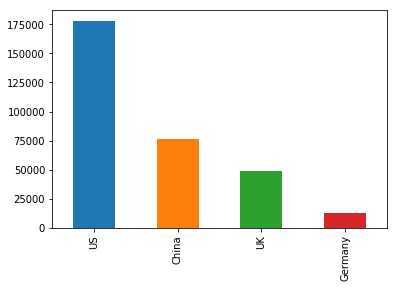

In [6]:
df['country'].value_counts().plot(kind='bar')

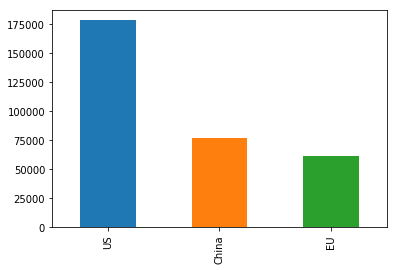

In [7]:
df['country_new'] = df['country']
b = np.array(df['country_new'].values.tolist())
df['country_new'] = np.where(b =="Germany" , "EU", b).tolist()
b = np.array(df['country_new'].values.tolist())
df['country_new'] = np.where(b =="UK" , "EU", b).tolist()
df['country_new'].value_counts().plot(kind='bar')

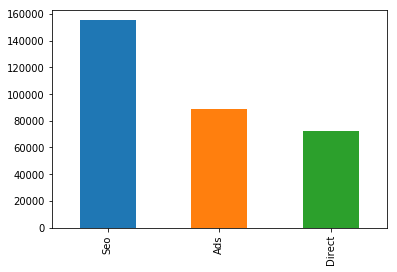

In [8]:
df['source'].value_counts().plot(kind='bar')

### 1.1 Check possible outlier

Then I checked whether there are outliers with extreme value in "age" or "total_pages_visited" and found out:

1.There are only two observations whose ages are greater than 100 while the age of all other observations is less than 80. However, it is still possible for human living longer than 123 years old. So, I decide to cap these two observations with 81(larger than 80, so I can tell these are capped observations).

2.The density of people visiting a given number of pages decreases gradually with the number of pages increases. This trend seems reasonable, so, I decide to leave it untounched.

#### Check "converted"

In [9]:
len(df[df['converted']==0])/len(df['converted'])

0.967741935483871

#### Check "age"

In [10]:
print("the distribution of age:",np.percentile(df['age'], [90,95,99,100]))

the distribution of age: [ 42.  45.  52. 123.]


(array([1.25006e+05, 1.35764e+05, 4.77200e+04, 7.37900e+03, 3.23000e+02,
        6.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([ 17. ,  27.6,  38.2,  48.8,  59.4,  70. ,  80.6,  91.2, 101.8,
        112.4, 123. ]),
 <a list of 10 Patch objects>)

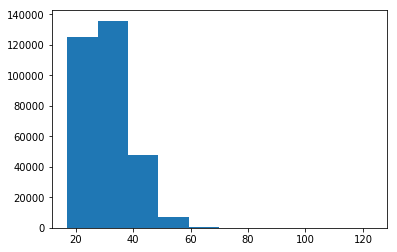

In [11]:
plt.hist(df['age'])

In [12]:
df_age52 = df[df['age']>52]

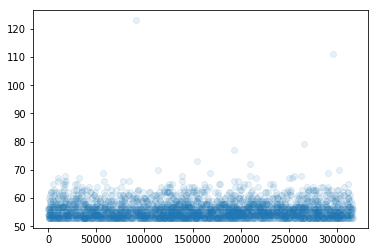

In [13]:
plt.scatter(x=df_age52.index.tolist(),y=df_age52['age'],alpha = 0.1)

In [14]:
print("the distribution of total_pages_visited:",np.percentile(df['total_pages_visited'], [90,95,99,100]))

the distribution of total_pages_visited: [ 9. 11. 17. 29.]


In [15]:
a = np.array(df['age'].values.tolist())
df['age'] = np.where(a > 80, 81, a).tolist()

#### Check "total_pages_visited"

(array([1.28436e+05, 1.07615e+05, 5.31670e+04, 1.70830e+04, 4.23600e+03,
        3.27000e+03, 1.69200e+03, 5.89000e+02, 1.02000e+02, 1.00000e+01]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

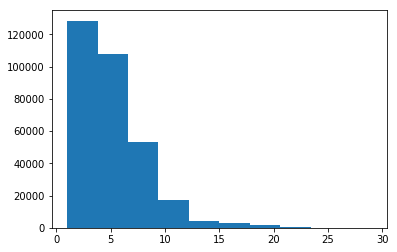

In [16]:
plt.hist(df['total_pages_visited'])

In [17]:
df_tpv17 = df[df['total_pages_visited']>17]

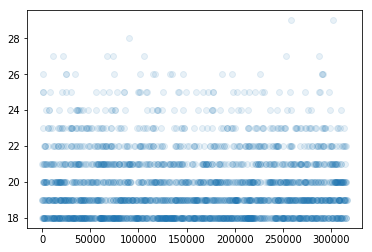

In [18]:
plt.scatter(x=df_tpv17.index.tolist(),y=df_tpv17['total_pages_visited'],alpha = 0.1)

### 1.3 Dataset Spliting

In [35]:
var_list = list(df.columns.values)
var_list.remove('converted')
var_list.remove('age_binned')
var_list.remove('tpv_binned')
var_list.remove('country_new')

In [36]:
X = df[var_list]
y = df['converted']

#### 2.1 Dummy Variables

In [37]:
cat_vars=['country','new_user','source']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(X[var], prefix=var)
    data1=X.join(cat_list)
    X=data1

data_vars=X.columns.values.tolist()
to_keep=list(set(data_vars)-set(cat_vars))

In [38]:
X=X[to_keep]
X.columns.values

array(['country_China', 'country_Germany', 'age', 'source_Direct',
       'country_US', 'new_user_1', 'new_user_0', 'country_UK',
       'source_Ads', 'source_Seo', 'total_pages_visited'], dtype=object)

#### 2.2 slipt into training testing dataset

#### 2.1 Standarized dataset

In [39]:
X.head(1)

,country_China,country_Germany,age,source_Direct,country_US,new_user_1,new_user_0,country_UK,source_Ads,source_Seo,total_pages_visited
0,0,0,25,0,0,1,0,1,1,0,1


In [40]:
cat = list(set(to_keep)-set(['age','total_pages_visited']))

In [41]:
standardized_X_n = pd.DataFrame(preprocessing.scale(X[['age','total_pages_visited']]))
standardized_X_c = X[cat]
standardized_X_n.columns = ['age','total_pages_visited']
standardized_X = pd.concat([standardized_X_n,standardized_X_c], axis=1)

/Users/jiangziqi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(standardized_X, y, test_size=0.33, random_state=42)

### 1.2 Univariate Analysis

According to the univariate-analysis, it is found that:

1.There are big difference in average conversion rate between different countries. It makes no sense to convert this variable into numeric one, so, I will keep this as a catgorical variable.

2.There are big difference in average conversion rate between new users or repeated users. It makes no sense to convert this variable into numeric one, so, I will keep this as a catgorical variable.

3.There are big difference in average conversion rate between different sources. It makes no sense to convert this variable into numeric one, so, I will keep this as a catgorical variable.

4.There are big difference in average conversion rate between different age groups and the relationship is not linear. But the conversion rate seems to be linear with the log(age). So, I would keep age as a numeric variable.

5.There are big difference in average conversion rate along with different total_pages_view and the relationship is roughly linear. So, I would keep total_pages_view as a numeric variable.

Because this is a classification problem with zero inflation, I tend to choose logistic regression for exploratory data analysis.

In [19]:
df['age_binned'] = pd.qcut(df['age'], 10)
df['tpv_binned'] = pd.qcut(df['total_pages_visited'], 5)

#### (1) Country

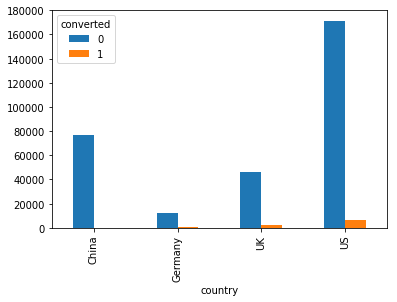

In [20]:
pd.crosstab(df.country,df.converted).plot(kind='bar')

In [21]:
df.groupby('country')['converted'].mean()

country
China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
Name: converted, dtype: float64

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a295ecac8>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2e864908>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2e83ef28>},
    x display_column   count  converted
 0  0  country_China   76602   0.001332
 1  1     country_US  178092   0.037801
 2  2     country_UK   48450   0.052632)

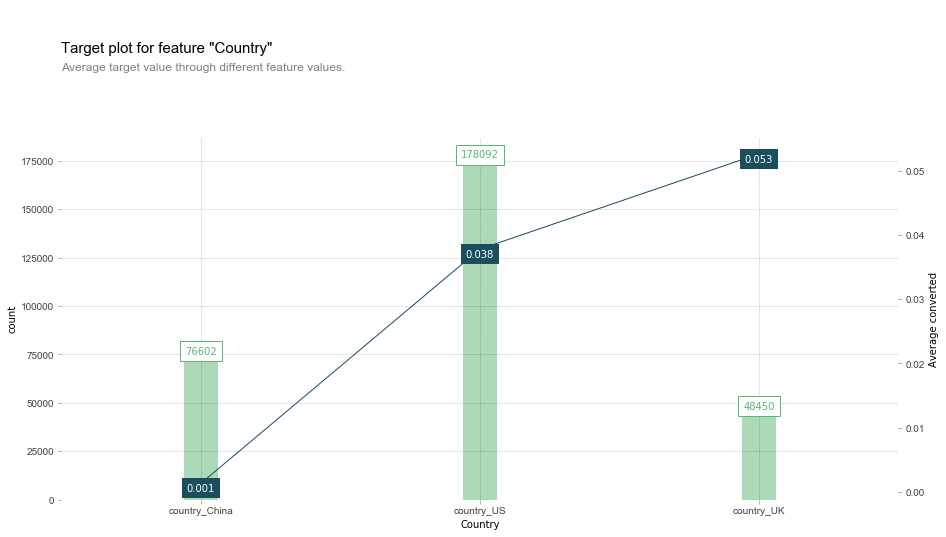

In [82]:
target_plot(df=a, feature=['country_China', 'country_US', 'country_UK'],
    feature_name='Country', target='converted')

#### (2) Source

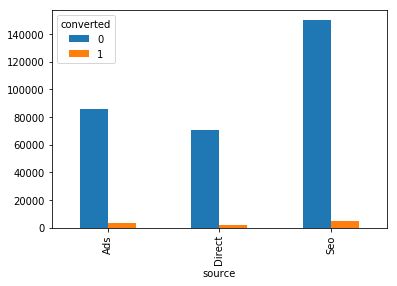

In [22]:
pd.crosstab(df.source,df.converted).plot(kind='bar')

In [23]:
df.groupby('source')['converted'].mean()

source
Ads       0.034483
Direct    0.028169
Seo       0.032895
Name: converted, dtype: float64

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x11c4854e0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a293526a0>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2622d2e8>},
    x display_column   count  converted
 0  0     source_Ads   88740   0.034483
 1  1  source_Direct   72420   0.028169
 2  2     source_Seo  155040   0.032895)

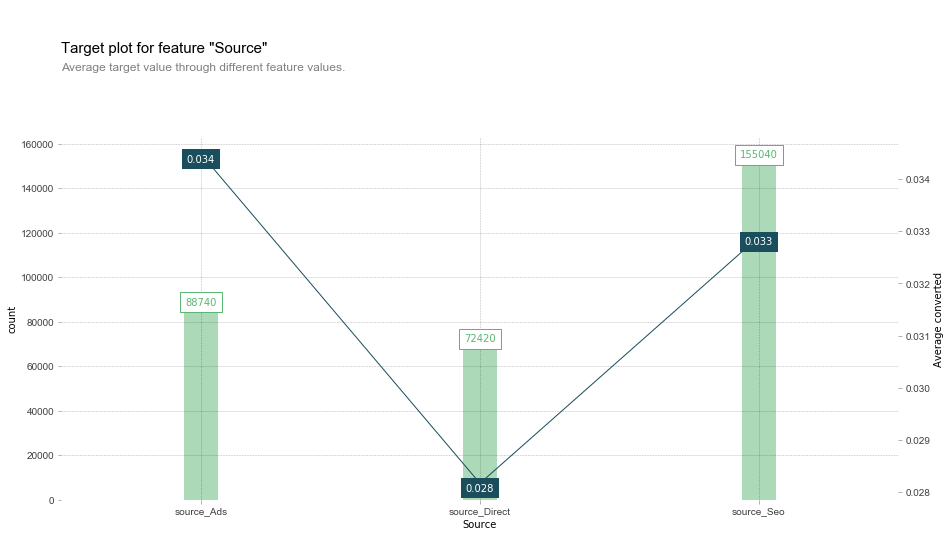

In [76]:
target_plot(df=a, feature=['source_Ads', 'source_Direct', 'source_Seo'],
    feature_name='Source', target='converted')

#### (3) new_user

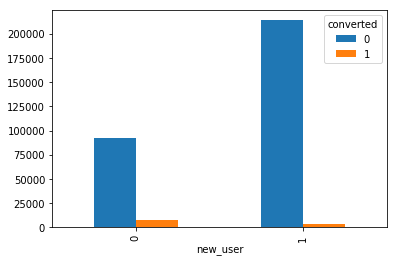

In [24]:
pd.crosstab(df.new_user,df.converted).plot(kind='bar')

In [25]:
df.groupby('new_user')['converted'].mean()

new_user
0    0.072002
1    0.014021
Name: converted, dtype: float64

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2e09a6a0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2e0605f8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a29e1ac18>},
    x display_column   count  converted
 0  0     new_user_1  216744   0.014021
 1  1     new_user_0   99456   0.072002)

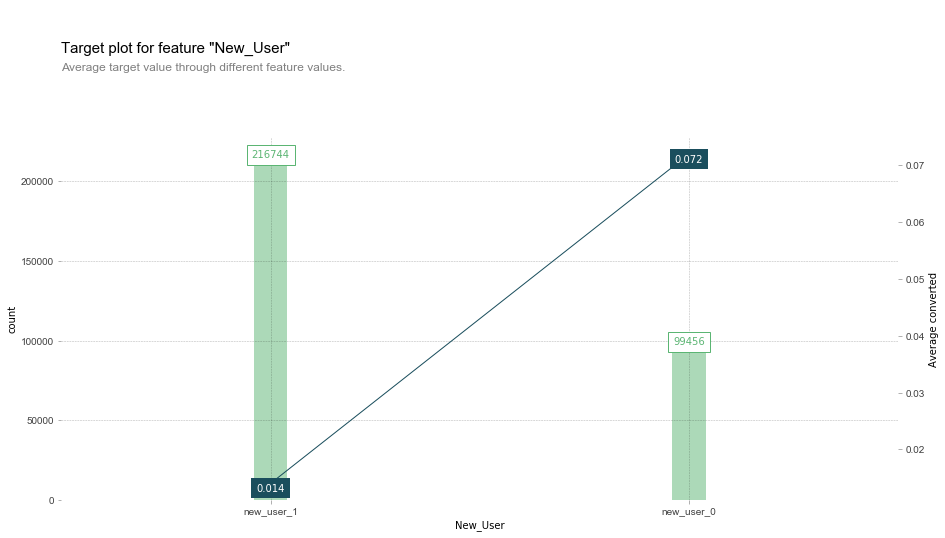

In [84]:
target_plot(df=a, feature=['new_user_1', 'new_user_0'],
    feature_name='New_User', target='converted')

#### (4) age

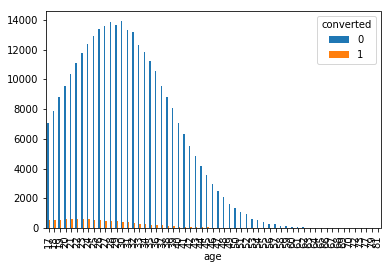

In [26]:
pd.crosstab(df.age,df.converted).plot(kind='bar')

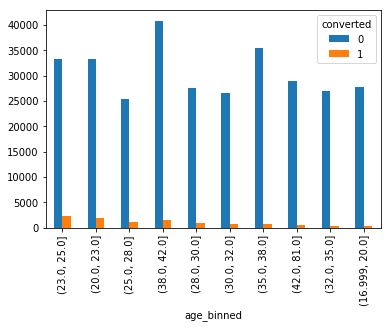

In [27]:
pd.crosstab(df.age_binned,df.converted).plot(kind='bar')

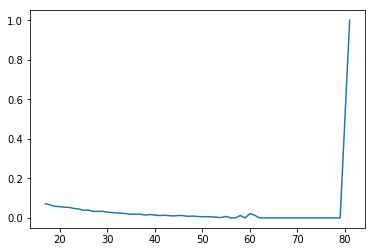

In [28]:
y_age = df.groupby('age')['converted'].mean()
x_age = df.groupby('age')['age'].mean()
plt.plot(x_age, y_age)

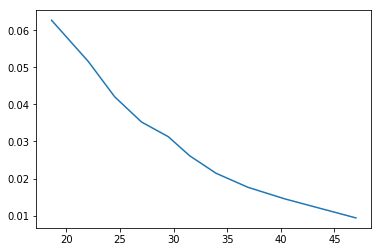

In [29]:
y_age_binned = df.groupby('age_binned')['converted'].mean()
x_age_binned = df.groupby('age_binned')['age'].mean()
plt.plot(x_age_binned, y_age_binned)

In [30]:
df.groupby('age_binned')['converted'].mean()

age_binned
(16.999, 20.0]    0.062725
(20.0, 23.0]      0.051624
(23.0, 25.0]      0.042051
(25.0, 28.0]      0.035249
(28.0, 30.0]      0.031294
(30.0, 32.0]      0.026141
(32.0, 35.0]      0.021403
(35.0, 38.0]      0.017621
(38.0, 42.0]      0.014521
(42.0, 81.0]      0.009362
Name: converted, dtype: float64

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a29327908>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a290cdf28>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a29542438>},
    x display_column  value_lower  value_upper percentile_column  \
 0  0       [17, 20)         17.0         20.0        [0, 11.11)   
 1  1       [20, 23)         20.0         23.0    [11.11, 22.22)   
 2  2       [23, 26)         23.0         26.0    [22.22, 33.33)   
 3  3       [26, 29)         26.0         29.0    [33.33, 44.44)   
 4  4       [29, 31)         29.0         31.0    [44.44, 55.56)   
 5  5       [31, 34)         31.0         34.0    [55.56, 66.67)   
 6  6       [34, 37)         34.0         37.0    [66.67, 77.78)   
 7  7       [37, 41)         37.0         41.0    [77.78, 88.89)   
 8  8       [41, 81]         41.0         81.0      [88.89, 100]   
 
    percentile_lower  percentile_upper  count  converted  
 0         

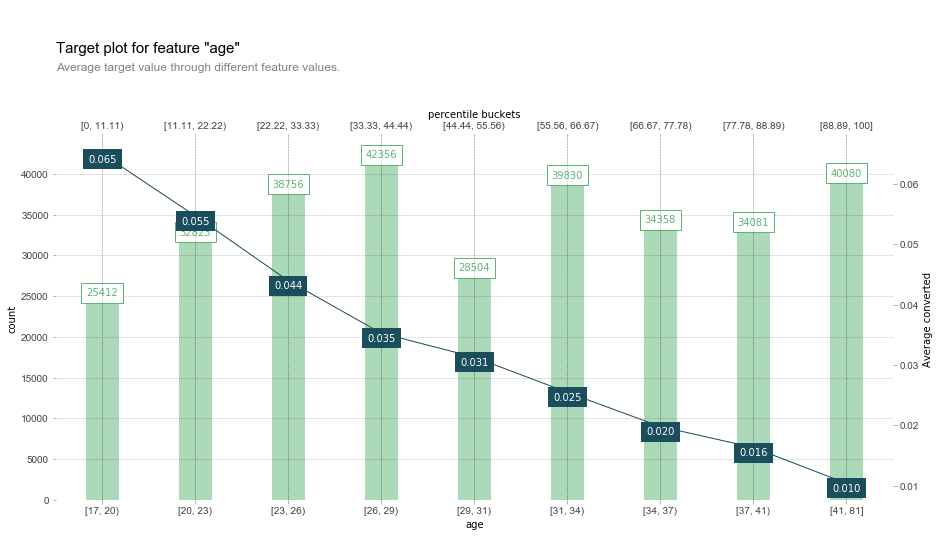

In [77]:
target_plot(
    df=a, feature='age', feature_name='age', target='converted', show_percentile=True)

#### (5) total_pages_visited

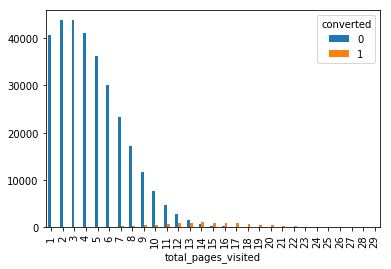

In [31]:
pd.crosstab(df.total_pages_visited,df.converted).plot(kind='bar')

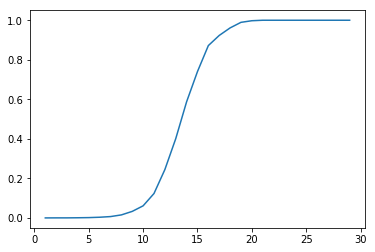

In [32]:
y_tpv = df.groupby('total_pages_visited')['converted'].mean()
x_tpv = df.groupby('total_pages_visited')['total_pages_visited'].mean()
plt.plot(x_tpv, y_tpv)

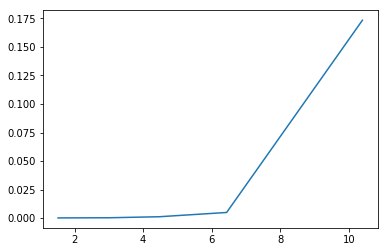

In [33]:
y_tpv_binned = df.groupby('tpv_binned')['converted'].mean()
x_tpv_binned = df.groupby('tpv_binned')['total_pages_visited'].mean()
plt.plot(x_tpv_binned, y_tpv_binned)

In [81]:
a = pd.concat([X,y],axis = 1)
a.columns

Index(['country_China', 'country_Germany', 'age', 'source_Direct',
       'country_US', 'new_user_1', 'new_user_0', 'country_UK', 'source_Ads',
       'source_Seo', 'total_pages_visited', 'converted'],
      dtype='object')

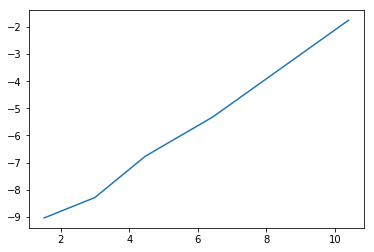

In [34]:
plt.plot(x_tpv_binned, np.log(y_tpv_binned.values))

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2b1092e8>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2b12c3c8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2a42c710>},
    x display_column  value_lower  value_upper percentile_column  \
 0  0         [1, 2)          1.0          2.0        [0, 22.22)   
 1  1         [2, 3)          2.0          3.0    [22.22, 33.33)   
 2  2         [3, 4)          3.0          4.0    [33.33, 44.44)   
 3  3         [4, 5)          4.0          5.0    [44.44, 55.56)   
 4  4         [5, 6)          5.0          6.0    [55.56, 66.67)   
 5  5         [6, 7)          6.0          7.0    [66.67, 77.78)   
 6  6         [7, 9)          7.0          9.0    [77.78, 88.89)   
 7  7        [9, 29]          9.0         29.0      [88.89, 100]   
 
    percentile_lower  percentile_upper  count  converted  
 0              0.00             22.22  40739   0.000000  
 1             22.22

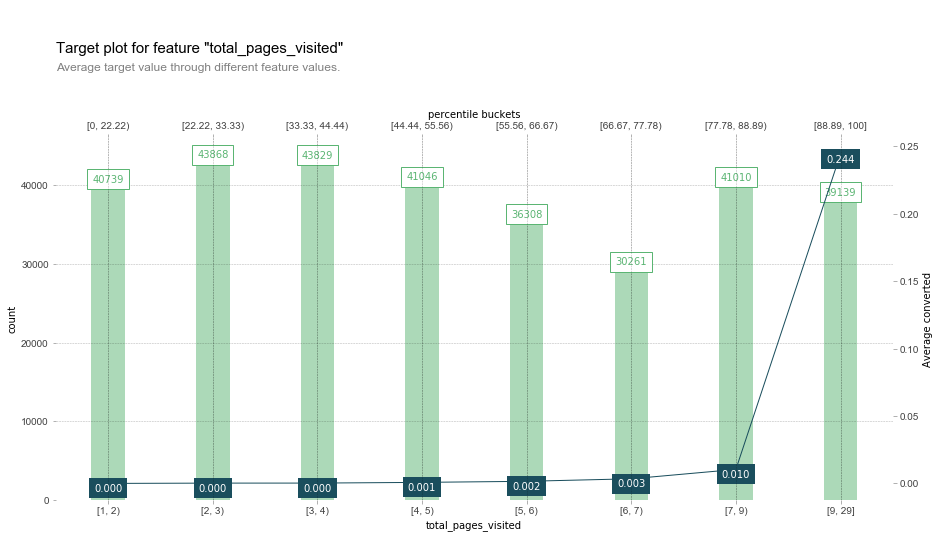

In [85]:
target_plot(
    df=a, feature='total_pages_visited', feature_name='total_pages_visited', target='converted', show_percentile=True)

#### 2.4 Logistic Model(standardized)

In [89]:
model_log_s = LogisticRegression().fit(X_train_s, y_train_s)

In [105]:
pd.DataFrame({'variables':list(X_train_s.columns),
              'standardized coef':model_log_s.coef_.tolist()[0]})

,variables,standardized coef
0,age,-0.631206
1,total_pages_visited,2.545304
2,country_China,-3.403330
3,country_Germany,0.228288
4,source_Direct,-1.264637
5,new_user_1,-2.595109
6,country_US,-0.329567
7,new_user_0,-0.839408
8,country_UK,0.070092
9,source_Ads,-1.076028


As it is shown in the graph and the standardized coefficients, 'country_China', 'new_user_1', 'total_pages_visited' are the most important variables. However,  'total_pages_visited' differs from case to case and it is almost impossible to get this information beforehanded. So, I would fit the model with and without this variable respectively.

### 3. Model Building

#### 3.1 Logistic Model(1st step)

In [44]:
model_log = LogisticRegression().fit(X_train, y_train)

/Users/jiangziqi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [45]:
y_pred_log = model_log.predict(X_test)

In [46]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model_log.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


In [47]:
cv_results_log = cross_validate(model_log, X, y, cv=3)
cv_results_log['test_score']

/Users/jiangziqi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiangziqi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiangziqi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.98627135, 0.98603416, 0.98614801])

According to the comparison between the accuracy on test set and the results from cross validations, it seems that the model is not overfitting. Also, the accuracy is higher than the proportion of zeros(0.9677), which means, this model has predictive power.

In [48]:
confusion_matrix_log = confusion_matrix(y_test, y_pred_log)
print(confusion_matrix_log)

[[100642    423]
 [  1013   2268]]


In [49]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101065
           1       0.84      0.69      0.76      3281

   micro avg       0.99      0.99      0.99    104346
   macro avg       0.92      0.84      0.88    104346
weighted avg       0.99      0.99      0.99    104346



According to the confusion matrix and these statistics, here are the findings:

1. According to the precisions, the model tend to make more type I error than type II error.

2. According to the recalls, the model doesn't perform very well in identifying all the true positive.

Overall, because the inflation of zero, the overall accuracy is 0.99.

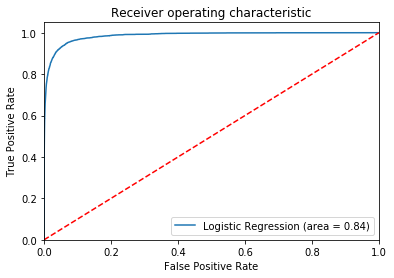

In [50]:
logit_roc_auc = roc_auc_score(y_test, model_log.predict(X_test))
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, model_log.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_log, tpr_log, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

According to the ROC Curve: It is showing the tradeoff between sensitivity and specificity. And the curve is close to the upper left coner, which indicates the test tend to be accurate.

The area under the curve(AUC) is between 0.8 and 0.9, which is good. 

#### 3.2 Logistic Model(2nd step)

In [118]:
X_train2 = X_train[X_train.columns.tolist()[:10]]
X2 = X[X_train.columns.tolist()[:10]]
X_test2 = X_test[X_train.columns.tolist()[:10]]

In [119]:
model_log2 = LogisticRegression().fit(X_train2, y_train)

In [120]:
y_pred_log2 = model_log2.predict(X_test2)

In [121]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model_log2.score(X_test2, y_test)))

Accuracy of logistic regression classifier on test set: 0.97


In [122]:
cv_results_log2 = cross_validate(model_log2, X2, y, cv=3)
cv_results_log2['test_score']

array([0.96774194, 0.96774194, 0.96774194])

According to the comparison between the accuracy on test set and the results from cross validations, it seems that the model is not overfitting. Also, the accuracy is higher than the proportion of zeros(0.9677), which means, this model has predictive power.

In [123]:
confusion_matrix_log2 = confusion_matrix(y_test, y_pred_log2)
print(confusion_matrix_log2)

[[101065      0]
 [  3281      0]]


In [124]:
print(classification_report(y_test, y_pred_log2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    101065
           1       0.00      0.00      0.00      3281

   micro avg       0.97      0.97      0.97    104346
   macro avg       0.48      0.50      0.49    104346
weighted avg       0.94      0.97      0.95    104346



According to the confusion matrix and these statistics, here are the findings:

1. According to the precisions, the model tend to make more type I error than type II error.

2. According to the recalls, the model doesn't perform very well in identifying all the true positive.

Overall, because the inflation of zero, the overall accuracy is 0.99.

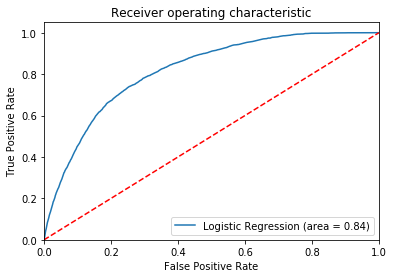

In [126]:
logit_roc_auc2 = roc_auc_score(y_test, model_log2.predict(X_test2))
fpr_log2, tpr_log2, thresholds_log = roc_curve(y_test, model_log2.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr_log2, tpr_log2, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### 3.2 Random Forest Model

In [127]:
model_rf = RandomForestClassifier(n_estimators=100,random_state = 42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(model_rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.98


In [128]:
confusion_matrix_rf = confusion_matrix(y_test, y_pred_log)
print(confusion_matrix_rf)

[[100642    423]
 [  1013   2268]]


In [129]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    101065
           1       0.80      0.67      0.73      3281

   micro avg       0.98      0.98      0.98    104346
   macro avg       0.90      0.83      0.86    104346
weighted avg       0.98      0.98      0.98    104346



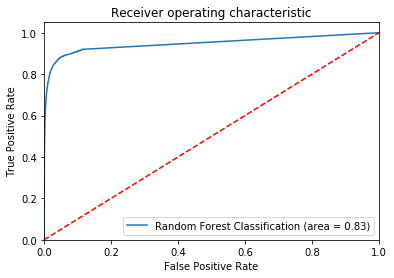

In [130]:
logit_roc_auc = roc_auc_score(y_test, model_rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_log = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest Classification (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [131]:
cv_results_rf = cross_validate(model_rf, X, y, cv=3)
cv_results_rf['test_score']

array([0.98410816, 0.98435484, 0.98469639])

In [132]:
feature_importances = pd.DataFrame(model_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

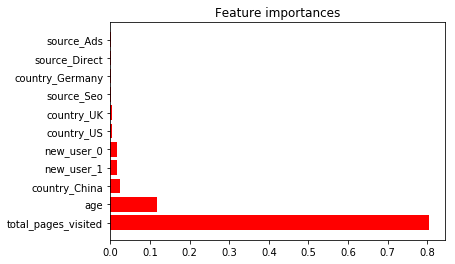

In [133]:
plt.figure()
plt.title("Feature importances")
plt.barh(feature_importances.index, feature_importances['importance'],
       color="r", align="center")
plt.show()